# Machine Learning for Life Science: Project 2 - Multilabel Protein Localization Prediction

# DATA

In [1]:
import os
import sys
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

train_labels = './data/train.csv'
train_images = './data/train/'

test_submission = './data/submission.csv'
test_images = './data/test/'

label_map = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles',
}

# variable for device (CPU or GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


Number of samples:  15389
Shape of image:  torch.Size([3, 128, 128])
Shape of label:  torch.Size([10]) 


Check first few labels:
    Image  Label
0      0  4 7 9
1      1  2 3 4
2      3      5 

 tensor([[0., 0., 0., 0., 1., 0., 0., 1., 0., 1.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]) 


Example image:


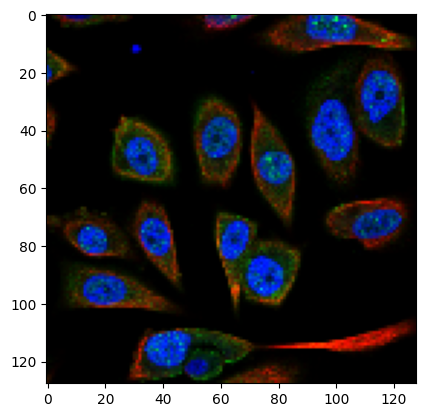

In [2]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer


class HumanProteinDataset(Dataset):
    def __init__(self, label_dir, img_dir, transform=None):

        self.df = pd.read_csv(label_dir).sort_values(by=['Image']).reset_index(drop=True)
        label_list = [[int(i) for i in label.split()] for label in self.df['Label']]
        mlb = MultiLabelBinarizer(classes=[i for i in range(10)])
        self.labels = torch.FloatTensor(mlb.fit_transform(label_list))

        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.img_dir + str(self.df['Image'].iloc[idx]) + '.png'
        image = read_image(img_path) / 255.0
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = HumanProteinDataset(label_dir=train_labels, img_dir=train_images)

print('Number of samples: ', len(train_dataset))
print('Shape of image: ', train_dataset[0][0].shape)
print('Shape of label: ', train_dataset[0][1].shape, '\n\n')

print('Check first few labels:\n', train_dataset.df.head(3), '\n\n', train_dataset.labels[:3], '\n\n')

print('Example image:')
plt.imshow(train_dataset.__getitem__(0)[0].permute(1, 2, 0))

Label count:
 tensor([1666., 1430., 2025., 1560., 7273.,  859., 4574., 2071.,  836., 1007.]) 

Label percent:
 tensor([0.1083, 0.0929, 0.1316, 0.1014, 0.4726, 0.0558, 0.2972, 0.1346, 0.0543,
        0.0654]) 



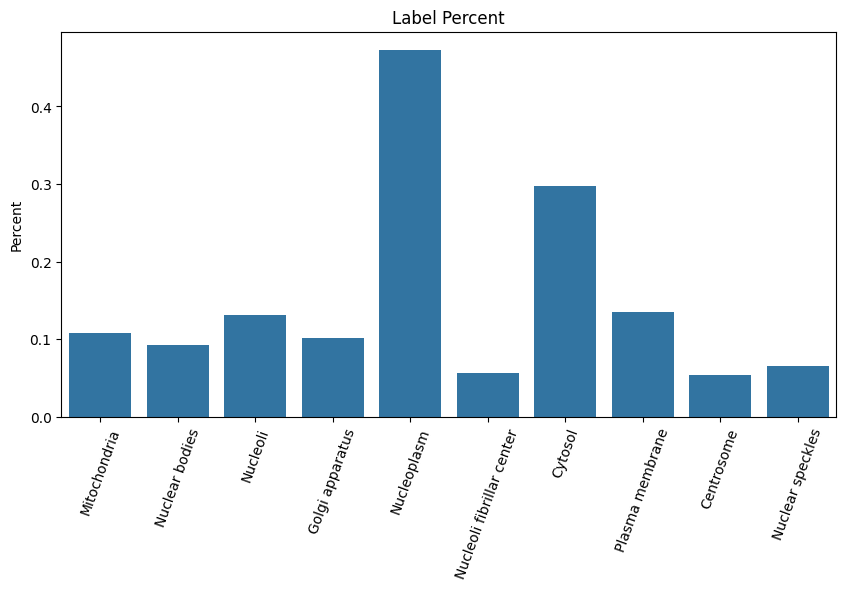

In [3]:
# check the distribution multi-class labels
n = len(train_dataset)
label_tensor = train_dataset.labels
label_count = torch.sum(label_tensor, dim=0)
label_percent = label_count / n

print('Label count:\n', label_count, '\n')
print('Label percent:\n', label_percent, '\n')

# plot label percent with label_map and seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x=list(label_map.values()), y=label_percent)
plt.xticks(rotation=70)
plt.ylabel('Percent')
plt.title('Label Percent')
plt.show()

We see there are some class-imbalances in the data.

In [4]:
from torch.utils.data import DataLoader

# split train_dataset into train and validation
split = int(0.8 * len(train_dataset))
index_list = list(range(len(train_dataset)))
train_idx, valid_idx = index_list[:split], index_list[split:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
valid_dataloader = DataLoader(train_dataset, batch_size=64, sampler=valid_sampler)

# test dataloader
test_batch = train_dataloader.__iter__().__next__()
print('Test batch shape\n', test_batch[0].shape, test_batch[1].shape)

Test batch shape
 torch.Size([64, 3, 128, 128]) torch.Size([64, 10])


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, channels = 64, kernel_size = 3):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding = "same"),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(channels)
            )

    def forward(self, x):
        return self.net(x) + x

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 3):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        return self.net(x)

class CNNBackBone(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            ConvBlock(3, 8, kernel_size=4),
            ResidualBlock(channels=8),
            nn.MaxPool2d(2),

            ConvBlock(8, 32, kernel_size=3),
            ResidualBlock(channels=32),
            nn.MaxPool2d(2),
            ResidualBlock(channels=32),
            nn.MaxPool2d(2),

            ConvBlock(32, 64, kernel_size=2),
            ResidualBlock(channels=64),
            nn.MaxPool2d(2),
        )

    def forward(self, x):
        return self.net(x)

print("Feature representation shape: ", CNNBackBone()(test_batch[0]).shape)

class LinearBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.2):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.BatchNorm1d(out_features),
        )

    def forward(self, x):
        return self.net(x)

class CNNHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Flatten(),
            LinearBlock(64 * 7 * 7, 64),
            LinearBlock(64, 32),
            nn.Linear(32, 10),
            # nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)

class ProteinLocalizer(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = CNNBackBone()
        self.head = CNNHead()

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

model = ProteinLocalizer()

# check output shape
test_x = torch.randn(32, 3, 128, 128)
print(model(test_x).shape)
print(model(test_batch[0]).shape)

# check number of parameters
sum([p.numel() for p in ProteinLocalizer().parameters()])

Feature representation shape:  torch.Size([64, 64, 7, 7])
torch.Size([32, 10])
torch.Size([64, 10])


270842

In [6]:
nn.Sigmoid()(model(test_batch[0])[0])

tensor([0.5774, 0.3452, 0.5795, 0.4392, 0.5379, 0.3445, 0.4283, 0.4500, 0.4454,
        0.5183], grad_fn=<SigmoidBackward0>)

In [7]:
test_batch[1][0]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [8]:
nn.Sigmoid()(model(test_batch[0])[3])

tensor([0.4085, 0.5733, 0.4718, 0.4016, 0.5185, 0.3418, 0.5560, 0.4641, 0.4739,
        0.4307], grad_fn=<SigmoidBackward0>)

In [9]:
test_batch[1][3]

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

Epoch 1
Train loss : 0.7181566431732376
Valid loss : 0.6976012307770398

Epoch 2
Train loss : 0.6780365013705634
Valid loss : 0.6454040663582938

Epoch 3
Train loss : 0.6433029971592167
Valid loss : 0.6174389732127287

Epoch 4
Train loss : 0.6140197654462232
Valid loss : 0.5958465094469032

Epoch 5
Train loss : 0.5862037780371354
Valid loss : 0.5663415485498856

Epoch 6
Train loss : 0.5605150285162457
Valid loss : 0.5390612543845663

Epoch 7
Train loss : 0.5355954877453147
Valid loss : 0.5196176852498736

Epoch 8
Train loss : 0.5122280411152025
Valid loss : 0.4999660521137471

Epoch 9
Train loss : 0.48962997540908776
Valid loss : 0.4774431300406553

Epoch 10
Train loss : 0.46899437811708206
Valid loss : 0.46065069400534336

Epoch 11
Train loss : 0.4495456623289869
Valid loss : 0.4406878431232608

Epoch 12
Train loss : 0.432316831202087
Valid loss : 0.4275530534131186

Epoch 13
Train loss : 0.41681947840927797
Valid loss : 0.40883208355125117

Epoch 14
Train loss : 0.4035618848751246
Va

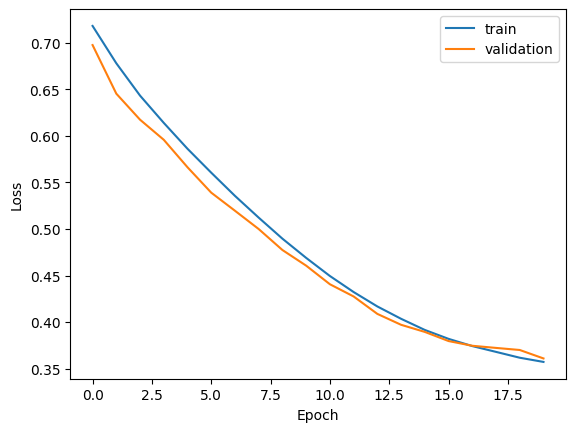

In [10]:
N_EPOCHS = 20
model = ProteinLocalizer()
model.to(device)

# loss function & optimizer
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.4)

# training loop
train_losses = []
val_losses = []

for i in range(1, N_EPOCHS + 1):
    print(f"Epoch {i}")
    train_loss = []
    val_loss = []

    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = batch
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # forward pass: run batch through our model, get predictions and compute loss
        y_hat_batch = model(X_batch)
        loss = loss_function(y_hat_batch, y_batch)
        train_loss.append(loss.item())

        # backward pass: compute gradients of loss w.r.t. model parameters and update weights
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for batch in valid_dataloader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # forward pass only
            y_hat_batch = model(X_batch)
            loss = loss_function(y_hat_batch, y_batch)
            val_loss.append(loss.item())

    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)
    print(f"Train loss : {mean_train_loss}")
    print(f"Valid loss : {mean_val_loss}\n")
    train_losses.append(mean_train_loss)
    val_losses.append(mean_val_loss)

plt.plot(np.arange(len(train_losses)), train_losses, label = "train")
plt.plot(np.arange(len(val_losses)), val_losses, label = "validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
nn.Sigmoid()(model(test_batch[0])[0])

tensor([0.2674, 0.1259, 0.1454, 0.1732, 0.2406, 0.1210, 0.4290, 0.2282, 0.1304,
        0.1121], grad_fn=<SigmoidBackward0>)

In [12]:
test_batch[1][0]

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [13]:
nn.Sigmoid()(model(test_batch[0])[3])

tensor([0.2489, 0.1384, 0.1622, 0.1930, 0.3188, 0.1159, 0.3728, 0.1507, 0.1390,
        0.1183], grad_fn=<SigmoidBackward0>)

In [14]:
test_batch[1][3]

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [15]:
# test dataset

class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = self.img_dir + self.img_names[idx]
        image = read_image(img_path) / 255.0

        if self.transform:
            image = self.transform(image)

        return image
    
test_dataset = TestDataset(img_dir=test_images)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [16]:
# make predictions
model.eval()
predictions = []

with torch.no_grad():
    for batch in test_dataloader:
        X_batch = batch
        X_batch = X_batch.to(device)
        y_hat_batch = nn.Sigmoid()(model(X_batch))
        predictions.append(y_hat_batch)

predictions = torch.cat(predictions, dim=0)
print(predictions.shape)

torch.Size([3847, 10])


In [17]:
predictions[0]

tensor([0.2124, 0.1505, 0.1594, 0.1809, 0.3724, 0.1118, 0.2893, 0.1324, 0.1198,
        0.1195])

In [18]:
nn.Sigmoid()(model(test_dataset[0].unsqueeze(0).to(device)))

tensor([[0.2124, 0.1505, 0.1594, 0.1809, 0.3724, 0.1118, 0.2893, 0.1324, 0.1198,
         0.1195]], grad_fn=<SigmoidBackward0>)

In [25]:
# format
#    ID,TARGET
#    2, 1 3
#    5,1
#    6, 2 4

threshold = 0.25
submission = pd.DataFrame()
submission['Image'] = [int(name.split('.')[0]) for name in test_dataset.img_names]
submission['Label'] = [' '.join([str(i) for i in range(10) if predictions[idx][i] >= threshold]) for idx in range(len(predictions))]
submission.head()

,Image,Label
0,10009,4 6
1,10024,4 6
2,10035,4 6 7
3,10040,
4,10050,0 6


In [26]:
# save submission
submission.to_csv('submission.csv', index=False)

In [ ]:
# Q: how to .gitignore the data folder
# A/ create a .gitignore file in the root directory
#    add the following line to the file
#    data/
#    save the file